In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
try: 
  import pyts.datasets
  from pyts.transformation import ShapeletTransform
except: 
  !pip install pyts
  !pip install tslearn
  import pyts.datasets
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour 
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from explainers import tfcounterfactual
import pandas as pd

import sklearn
import warnings
from scipy.spatial import distance
warnings.simplefilter("ignore", UserWarning)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle


In [ ]:
def shapelet_category(y_train, indices, label):
    labels = y_train[indices.iloc[:, 0]]
    labels = pd.DataFrame(labels)
    frames = [indices, labels]
    res = pd.concat(frames, axis=1)
    res.columns=["idx", "start_point", "end_point", "label"]
    res = res.groupby('label')
    res = res.get_group(label).head(2)
    res = np.array(res)
    return res

In [ ]:
def get_shapelet(X_train, y_train, len_ts):

    a = int(len_ts * 0.2)
    b = int(len_ts * 0.4)
    c = int(len_ts * 0.6)
   
    st = ShapeletTransform(n_shapelets=100, window_sizes=[ a, b, c],
                           random_state=42, sort=True)
    st.fit_transform(X_train, y_train)
    indices = pd.DataFrame(st.indices_)
    return indices


In [ ]:
DS = 'Coffee'
colors= ['red','green']
print("Loading Dataset.."+str(DS))
xtrain, xtest, ytrain, ytest_ = pyts.datasets.fetch_ucr_dataset(dataset=DS, return_X_y=True)
classes =np.unique(ytest_)
nb_classes = len(classes)

len_ts = xtrain.shape[1]
idx_shapelets = get_shapelet(xtrain, ytrain, len_ts)  # index, start_point, end_point
shapelets = []
for i in classes:
    shapelets.append(shapelet_category(ytrain, idx_shapelets, i))
print("shapelets:")
print(shapelets)

shapelet_dic = {}
for cls in range(nb_classes):
    shapelet_dic[cls] = xtrain[shapelets[cls][0][0]][shapelets[cls][0][1]:shapelets[cls][0][2]]

Loading Dataset..Coffee
shapelets:
[array([[ 11, 213, 270,   0],
       [  0,  69, 183,   0]]), array([[ 21, 198, 255,   1],
       [ 24, 122, 236,   1]])]


Number of Classes 2
(286,)


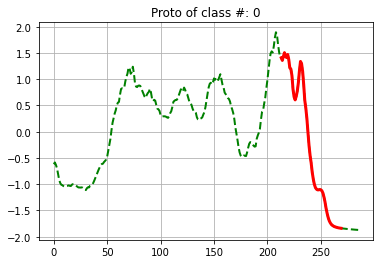

(286,)


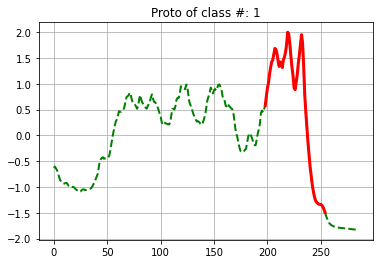

In [ ]:
print("Number of Classes "+str(nb_classes))
proto_dic = {}
protoptypes_lst = []

enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
enc.fit(np.concatenate((ytrain, ytest_), axis=0).reshape(-1, 1))
ytrain = enc.transform(ytrain.reshape(-1, 1)).toarray()
ytest = enc.transform(ytest_.reshape(-1, 1)).toarray()

    
for cls in range(len(classes)):
  proto_dic[cls] = xtrain[shapelets[cls][0][0]]
  print(proto_dic[cls].shape)
  plt.plot(proto_dic[cls], linestyle="--",color='green', linewidth=2)
  plt.plot(np.arange(shapelets[cls][0][1], shapelets[cls][0][2]), xtrain[shapelets[cls][0][0], shapelets[cls][0][1]:shapelets[cls][0][2]],
                 lw=3, color='red')
  plt.title("Proto of class #: "+str(cls))
  plt.grid()
  plt.show()

In [ ]:

xtrain = np.reshape(np.array(xtrain),(xtrain.shape[0], xtrain.shape[1],1))
xtest = np.reshape(np.array(xtest),(xtest.shape[0], xtest.shape[1],1))

cnn = load_model(path + '/fcn_weights/' + DS + '_best_model.hdf5')  
score = cnn.evaluate(xtest, ytest, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  1.0


Counterfactual explanation from arabica to robusta coffee species


Test sample class is 0
sorted list is [1]
choice0
Explanation using prototype class 1
Model is Keras...
[[9.9954933e-01 4.5061874e-04]]
One hot of targhet is [[1. 0.]]
[1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09 1.e-10]
Number of steps 50
The lower bound lambda is [0.01]
Found the optimal lambda at [0.055]
Prob array is
0
CF SEG IS 14
The Original predicted class is [[9.9954933e-01 4.5061874e-04]]
The CF predicted class is [[0.00494608 0.9950539 ]]
0.9950539
The rate is 0.060000000000000005
++++++++++++++++++++++++++++++++++++++++++
finish one


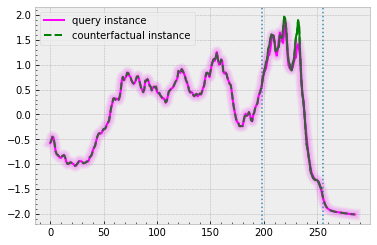

In [ ]:
for instance in [0]: 
  X = xtest[instance].reshape((1,) + xtest[0].shape)
  shape = (1,) + xtrain.shape[1:]
  target_proba = 1
  tol = 0.01 # want counterfactuals with p(class)>0.99
  target_class = 'other'
  max_iter = 500
  lam_init = 1e-1
  max_lam_steps = 1
  learning_rate_init = 0.1
  feature_range = (xtrain.min(),xtrain.max())

  otherclasses_lst = list(shapelet_dic.keys())
  otherclasses_lst.remove(list(ytest[instance:instance+1][0]).index(1))
  print("Test sample class is "+str(list(ytest[instance:instance+1][0]).index(1)))

  protoDistance_dic ={}
  for c in otherclasses_lst:
    tmp = sum(abs(val1-val2) for val1, val2 in zip(xtest[instance:instance + 1].reshape(1,len(proto_dic[c]))[0], proto_dic[c]))
    protoDistance_dic[c] = tmp

  otherclasses_lst =[]
  for i in range(nb_classes-1):
    minval = min(protoDistance_dic.values())
    res = [k for k, v in protoDistance_dic.items() if v == minval][0]
    del protoDistance_dic[res]

    otherclasses_lst.append(res)

  print("sorted list is "+str(otherclasses_lst))

       
  for i, c  in enumerate(otherclasses_lst[:3]):
    print("choice"+str(i))
    len_shape = len(shapelet_dic[c]) 

    shapelet = shapelet_dic[c].reshape((1, len_shape, 1))
    start_idx = shapelets[c][0][1]
    end_idx = shapelets[c][0][2]
    print("Explanation using prototype class "+str(c))
   
    cf = tfcounterfactual.TFCounterFactual(cnn, shape=shape, target_proba=target_proba, tol=tol,  #outlier_model=outlier_model,
                                           target_class=c, target_classid = c,max_iter=max_iter, lam_init=lam_init,
                                           max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                                           feature_range=feature_range, tstID=i, dataset=DS, num_classes=nb_classes, choice=i,
                                           len_shapelet=len_shape,shapelet=shapelet,start_idx = start_idx, end_idx = end_idx) #target_class

    explanation = cf.explain(X, proto_dic[c].reshape((1,) + xtest[0].shape))
            
    
    a = explanation.cf
    b = np.reshape(X, (1, X.shape[1]))[0]

Counterfactual explanation from robusta to arabica coffee species


Test sample class is 1
sorted list is [0]
choice0
Explanation using prototype class 0
Model is Keras...
[[1.2294727e-05 9.9998772e-01]]
One hot of targhet is [[0. 1.]]
[1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09 1.e-10]
Number of steps 50
The lower bound lambda is [0.01]
Found the optimal lambda at [0.055]
Prob array is
0
CF SEG IS 14
The Original predicted class is [[1.2294727e-05 9.9998772e-01]]
The CF predicted class is [[0.9783633  0.02163678]]
0.9783633
The rate is 0.060000000000000005
++++++++++++++++++++++++++++++++++++++++++
finish one


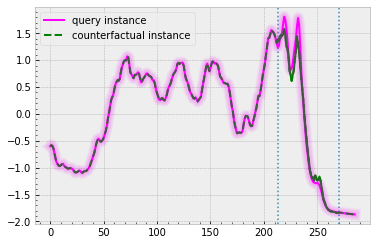

In [ ]:
for instance in [25]: 
  X = xtest[instance].reshape((1,) + xtest[0].shape)
  shape = (1,) + xtrain.shape[1:]
  target_proba = 1
  tol = 0.01 # want counterfactuals with p(class)>0.99
  target_class = 'other' 
  max_iter = 500
  lam_init = 1e-1
  max_lam_steps = 1
  learning_rate_init = 0.1
  feature_range = (xtrain.min(),xtrain.max())

  otherclasses_lst = list(shapelet_dic.keys())
  otherclasses_lst.remove(list(ytest[instance:instance+1][0]).index(1))
  print("Test sample class is "+str(list(ytest[instance:instance+1][0]).index(1)))

  protoDistance_dic ={}
  for c in otherclasses_lst:
    tmp = sum(abs(val1-val2) for val1, val2 in zip(xtest[instance:instance + 1].reshape(1,len(proto_dic[c]))[0], proto_dic[c]))
    protoDistance_dic[c] = tmp

  otherclasses_lst =[]
  for i in range(nb_classes-1):
    minval = min(protoDistance_dic.values())
    res = [k for k, v in protoDistance_dic.items() if v == minval][0]
    del protoDistance_dic[res]

    otherclasses_lst.append(res)

  print("sorted list is "+str(otherclasses_lst))

        
  for i, c  in enumerate(otherclasses_lst[:3]):
    print("choice"+str(i))
    len_shape = len(shapelet_dic[c])  

    shapelet = shapelet_dic[c].reshape((1, len_shape, 1))
    start_idx = shapelets[c][0][1]
    end_idx = shapelets[c][0][2]
    print("Explanation using prototype class "+str(c))
    
    cf = tfcounterfactual.TFCounterFactual(cnn, shape=shape, target_proba=target_proba, tol=tol,  #outlier_model=outlier_model,
                                           target_class=c, target_classid = c,max_iter=max_iter, lam_init=lam_init,
                                           max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                                           feature_range=feature_range, tstID=i, dataset=DS, num_classes=nb_classes, choice=i,
                                           len_shapelet=len_shape,shapelet=shapelet,start_idx = start_idx, end_idx = end_idx) #target_class

    explanation = cf.explain(X, proto_dic[c].reshape((1,) + xtest[0].shape))
            
    
    a = explanation.cf
    b = np.reshape(X, (1, X.shape[1]))[0]